forked from main iowa_redistricting on march 28

manually implementing algorithm described in Chen and Rodden (2013)

Shapefile dataframes used in this notebook

shapefile_iowa: MGGG stuff merged with census stuff

shapef_ia_proj: projected to UTM so we can run distance calculations on it

shapef_ia_fordistricting: 99 rows for each county, ready for initial allocation; made from deep copy of shapef_ia_proj

shapef_counties_for_realloc: made from a deep copy from shapef_ia_fordistricting; this has a num_switches column and a district column populated with the district assignment from the initial allocation

shapef_ia_initialdistricting: came from _fordistricting, went through the districting (step 1/2) process, and is now 4 rows
	as of Sept 18, not modified further for step 3/district balancing

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
from PIL import Image, ImageOps
from plotnine import (ggplot, aes, geom_map, geom_text, geom_label, 
                      ggtitle, element_blank, element_rect, 
                      scale_fill_manual, theme_minimal, theme) 
from pulp import (LpProblem, LpMinimize, LpVariable, lpSum, 
                  PULP_CBC_CMD, GLPK_CMD, LpStatus, value) 


import math         ##for math.sqrt
import random       #for random selection of district to start with

# Prepping the census and geopandas dataframes

## Importing data

In [2]:
census_df=pd.read_csv('census.csv')
census_df['COUNTYFP10']=census_df['COUNTYFP10'].astype(str).str.pad(3,fillchar='0')
census_df.head()

,county_id,county,population,COUNTYFP10,latitude,longitude
0,0,Adair,7496,001,41.328528,-94.478164
1,1,Adams,3704,003,41.021656,-94.696906
2,2,Allamakee,14061,005,43.274964,-91.382751
3,3,Appanoose,12317,007,40.744683,-92.870345
4,4,Audubon,5674,009,41.679178,-94.904312


In [3]:
#imports county shapefiles from MGGG
shapefile_iowa = gpd.read_file('IA_counties/IA_counties.shp').sort_values('NAME10',ignore_index=True)
shapefile_iowa.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 57 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   STATEFP10   99 non-null     object  
 1   COUNTYFP10  99 non-null     object  
 2   GEOID10     99 non-null     int64   
 3   NAME10      99 non-null     object  
 4   NAMELSAD10  99 non-null     object  
 5   ALAND10     99 non-null     int64   
 6   AWATER10    99 non-null     int64   
 7   INTPTLAT10  99 non-null     object  
 8   INTPTLON10  99 non-null     object  
 9   TOTPOP      99 non-null     int64   
 10  NH_WHITE    99 non-null     int64   
 11  NH_BLACK    99 non-null     int64   
 12  NH_AMIN     99 non-null     int64   
 13  NH_ASIAN    99 non-null     int64   
 14  NH_NHPI     99 non-null     int64   
 15  NH_OTHER    99 non-null     int64   
 16  NH_2MORE    99 non-null     int64   
 17  HISP        99 non-null     int64   
 18  H_WHITE     99 non-null     int64   
 19  H_

In [4]:
## Merging ONLY 2020 population #s and county_id from census df into shapefile_iowa
shapefile_iowa = shapefile_iowa.merge(census_df[['COUNTYFP10','population','county_id']], on='COUNTYFP10').copy()

#(otherwise this merge is only done for the map point later)

In [5]:
county_populations = np.array(census_df['population'])
state_population = sum(county_populations)
n_counties = 99
n_districts = 4
# top_fifth_percentile=int(np.percentile(census_df['population'],95))       # not needed here/yet, maybe later

## Projecting shapefile to UTM 15N

In [6]:
#First, show the current coordinate reference system
shapefile_iowa.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

In [7]:
#Then project the shapefiles to UTM 15N
shapef_ia_proj = shapefile_iowa.to_crs(epsg=26915)

shapef_ia_proj.crs
# new_districts_shapefile_projected.crs

<Derived Projected CRS: EPSG:26915>
Name: NAD83 / UTM zone 15N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: North America - between 96°W and 90°W - onshore and offshore. Canada - Manitoba; Nunavut; Ontario. United States (USA) - Arkansas; Illinois; Iowa; Kansas; Louisiana; Michigan; Minnesota; Mississippi; Missouri; Nebraska; Oklahoma; Tennessee; Texas; Wisconsin.
- bounds: (-96.0, 25.61, -90.0, 84.0)
Coordinate Operation:
- name: UTM zone 15N
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [8]:
shapef_ia_proj[['geometry']]

,geometry
0,"POLYGON ((386139.673 4557123.147, 385899.972 4..."
1,"POLYGON ((347722.464 4557927.937, 347913.212 4..."
2,"POLYGON ((621990.182 4817526.586, 622024.806 4..."
3,"POLYGON ((491767.058 4517888.762, 491767.214 4..."
4,"POLYGON ((325801.578 4617291.999, 325803.323 4..."
...,...
94,"POLYGON ((421445.925 4808992.344, 421447.824 4..."
95,"POLYGON ((574463.517 4808850.424, 574456.858 4..."
96,"POLYGON ((219197.456 4698279.860, 219185.953 4..."
97,"POLYGON ((469254.825 4789243.586, 469110.920 4..."


In [9]:
#checking out geopandas automatic distance calculation
shapef_ia_proj['geometry'].iloc[0].distance(shapef_ia_proj['geometry'].iloc[1])
# adair-to-adams distance is 0, so shortest distance, not centroid-to-centroid

0.0

## Merging pd and gpd dataframes and creating population heat map

In [10]:
shapefile_iowa.columns

Index(['STATEFP10', 'COUNTYFP10', 'GEOID10', 'NAME10', 'NAMELSAD10', 'ALAND10',
       'AWATER10', 'INTPTLAT10', 'INTPTLON10', 'TOTPOP', 'NH_WHITE',
       'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 'NH_NHPI', 'NH_OTHER', 'NH_2MORE',
       'HISP', 'H_WHITE', 'H_BLACK', 'H_AMIN', 'H_ASIAN', 'N_NHPI', 'H_OTHER',
       'H_2MORE', 'VAP', 'HVAP', 'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP',
       'NHPIVAP', 'OTHERVAP', '2MOREVAP', 'TOTVOT00', 'PRES00D', 'PRES00R',
       'PRES00G', 'PRES00OTH', 'TOTVOT04', 'PRES04D', 'PRES04R', 'PRES04OTH',
       'TOTVOT08', 'PRES08D', 'PRES08R', 'PRES08OTH', 'TOTVOT12', 'PRES12D',
       'PRES12R', 'PRES12OTH', 'TOTVOT16', 'PRES16D', 'PRES16R', 'PRES16OTH',
       'CD', 'geometry', 'population', 'county_id'],
      dtype='object')

In [11]:
# census_df.sort_values('population', ascending=False).head()
census_df.columns

Index(['county_id', 'county', 'population', 'COUNTYFP10', 'latitude',
       'longitude'],
      dtype='object')

In [12]:
# old version
# map_population_by_county_data = shapefile_iowa.merge(census_df, on='COUNTYFP10')


## Merging ONLY lat/long + county id from census df into shapefile_iowa (since population and county_id are already there)
map_population_by_county_data = shapefile_iowa.merge(census_df[['COUNTYFP10','latitude','longitude']], on='COUNTYFP10').copy()

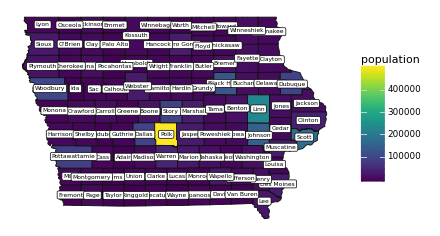

<ggplot: (356391297)>

In [13]:
map_population_by_county = (
    ggplot(map_population_by_county_data)
    + geom_map(aes(fill='population'))
    + geom_label(aes(x='longitude', y='latitude', 
                     label='NAME10',size=2), 
                 show_legend=False)
    + theme_minimal()
    + theme(axis_text_x=element_blank(),
            axis_text_y=element_blank(),
            axis_title_x=element_blank(),
            axis_title_y=element_blank(),
            axis_ticks=element_blank(),
            panel_grid_major=element_blank(),
            panel_grid_minor=element_blank()
           )
    )
map_population_by_county

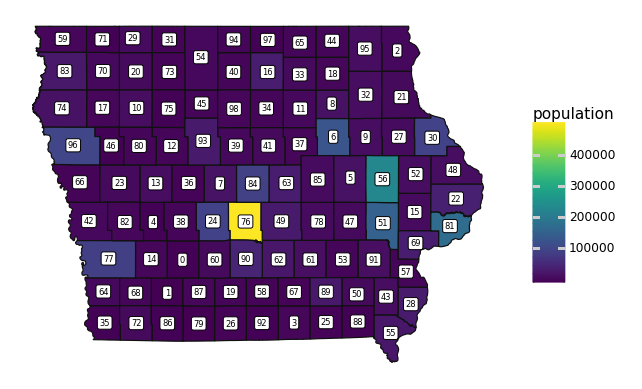

<ggplot: (356352685)>

In [14]:
map_by_county_id = (
    ggplot(map_population_by_county_data)
    + geom_map(aes(fill='population'))
    + geom_label(aes(x='longitude', y='latitude', 
                     label='county_id',size=2), 
                 show_legend=False)
    + theme_minimal()
    + theme(axis_text_x=element_blank(),
            axis_text_y=element_blank(),
            axis_title_x=element_blank(),
            axis_title_y=element_blank(),
            axis_ticks=element_blank(),
            panel_grid_major=element_blank(),
            panel_grid_minor=element_blank()
           )
    )
map_by_county_id

# Creating the adjacency matrix for Iowa counties

In [15]:
##########original version keeping here temporarily: superceded by function later

# # full statewide adjacency matrix (first boolean, then casting as int)
# #   NOTE: this operation counts a county as adjacent to itself. subtract eye(99) to get a more traditional version
# #   also should do this operation after any sorting of the original shapefile

# ia_adjac_matrix = pd.DataFrame()

# for j in range(n_counties):
#     ia_adjac_matrix[j] = shapefile_iowa.intersects(shapefile_iowa.iloc[[j]].unary_union)
# ia_adjac_matrix = ia_adjac_matrix - np.identity(99)
# ia_adjac_matrix = ia_adjac_matrix.astype(int)

# ia_adjac_matrix_bool = ia_adjac_matrix.astype(bool)



# Creating distance matrix for Iowa counties

In [16]:
# adding/fixing columns with (projected) centroid locations 
shapef_ia_proj['xcentr_lon'] = shapef_ia_proj.centroid.x
shapef_ia_proj['ycentr_lat'] = shapef_ia_proj.centroid.y
#shapef_ia_proj.info()
# shapef_ia_proj['xcentr_lon'].iloc[1]

In [17]:
shapef_ia_proj.columns

Index(['STATEFP10', 'COUNTYFP10', 'GEOID10', 'NAME10', 'NAMELSAD10', 'ALAND10',
       'AWATER10', 'INTPTLAT10', 'INTPTLON10', 'TOTPOP', 'NH_WHITE',
       'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 'NH_NHPI', 'NH_OTHER', 'NH_2MORE',
       'HISP', 'H_WHITE', 'H_BLACK', 'H_AMIN', 'H_ASIAN', 'N_NHPI', 'H_OTHER',
       'H_2MORE', 'VAP', 'HVAP', 'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP',
       'NHPIVAP', 'OTHERVAP', '2MOREVAP', 'TOTVOT00', 'PRES00D', 'PRES00R',
       'PRES00G', 'PRES00OTH', 'TOTVOT04', 'PRES04D', 'PRES04R', 'PRES04OTH',
       'TOTVOT08', 'PRES08D', 'PRES08R', 'PRES08OTH', 'TOTVOT12', 'PRES12D',
       'PRES12R', 'PRES12OTH', 'TOTVOT16', 'PRES16D', 'PRES16R', 'PRES16OTH',
       'CD', 'geometry', 'population', 'county_id', 'xcentr_lon',
       'ycentr_lat'],
      dtype='object')

In [18]:
# cutting out other columns from the shapefile to be dissolved on

# 'TOTPOP' is the MGGG shapefile totpop (pre-2020), so removing
# also removing: the un-projected 'INTPTLAT10' and 'INTPTLON10'
#      and 'NAMELSAD10', the 2 word name
#      and all demographic/voting data
#      and (later on): also removing ALAND and AWATER, since they just get messy with merges and dissolves

districting_columns = ['COUNTYFP10', 'NAME10', 'geometry', 
       'population', 'county_id', 'xcentr_lon', 'ycentr_lat']

#make a new shapefile, which will be merged/dissolved on in the process of making districts
shapef_ia_fordistricting = shapef_ia_proj[districting_columns].copy()

#add column of county indices (which will get concatenated, as county_id_string)
shapef_ia_fordistricting['county_id_string'] = shapef_ia_fordistricting['county_id']
shapef_ia_fordistricting['county_id_string'] = shapef_ia_fordistricting['county_id_string'].astype(str).str.pad(2,fillchar='0')

#add column of county indices (which will become district indices)
shapef_ia_fordistricting['temp_district'] = shapef_ia_fordistricting.index

shapef_ia_fordistricting.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 99 entries, 0 to 98
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   COUNTYFP10        99 non-null     object  
 1   NAME10            99 non-null     object  
 2   geometry          99 non-null     geometry
 3   population        99 non-null     int64   
 4   county_id         99 non-null     int64   
 5   xcentr_lon        99 non-null     float64 
 6   ycentr_lat        99 non-null     float64 
 7   county_id_string  99 non-null     object  
 8   temp_district     99 non-null     int64   
dtypes: float64(2), geometry(1), int64(3), object(3)
memory usage: 7.7+ KB


In [19]:
########## # superceded by/included in function below

# # full statewide distance matrix

# ia_dist_matrix = np.zeros((n_counties,n_counties))

# for i in range(n_counties):
#     for j in range(n_counties):
#         x_dist = (shapef_ia_proj['xcentr_lon'].iloc[i] - shapef_ia_proj['xcentr_lon'].iloc[j])
#         y_dist = (shapef_ia_proj['ycentr_lat'].iloc[i] - shapef_ia_proj['ycentr_lat'].iloc[j])
#         ia_dist_matrix[i,j] = math.sqrt(x_dist**2 + y_dist**2)

# # ia_dist_matrix


In [20]:
# testing randint

# lst = []
# for i in range(1000):
#     lst.append(random.randint(0,n_counties))
# # print(lst)
# max_rand = max(lst)
# min_rand = min(lst)
# # lst
# print("The maximum element is ", max_rand, ". The minimum element is ", min_rand, ".")

# Nearest-Neighbor district-building model

* To start, we have 99 districts, 1 for each county.
* Randomly select a district (single county at the moment!) to start with.
* Join it to its nearest neighbor (using centroid measurement of distance).
    * Make new shapefile with those two counties dissolved together (and calc new centroids/distances)
    * Now we have 98 districts. Repeat until 4 left.

This procedure preserves compactness well, but has no population controls.
After we're down to 4 districts, we will then swap counties between districts until populations stabilize.


## Building-block functions (adjacency matrix + distance matrix)

In [21]:
# function for arbitrary adjacency matrix

def adj_mat_calc(temp_shapefile):
    curr_n_districts = len(temp_shapefile)
    adjac_mat = pd.DataFrame()

    for i in range(curr_n_districts):
        adjac_mat[i] = temp_shapefile.intersects(temp_shapefile.iloc[[i]].unary_union)
    
    adjac_mat = adjac_mat - np.identity(curr_n_districts)
    adjac_mat = adjac_mat.astype(int)

    #and/or boolean?
    # ia_adjac_matrix_bool = ia_adjac_matrix.astype(bool)

    return adjac_mat


In [22]:
#function: input is a shapefile with centroid columns, output is a distance matrix
def temp_distance_matrix(temp_shapefile):
    curr_n_districts = len(temp_shapefile)
    distance_mat = np.zeros((curr_n_districts,curr_n_districts))

    for i in range(curr_n_districts):
        for j in range(i):      #just do half the triangle, so indices from 0 to i-1
            x_dist = (temp_shapefile['xcentr_lon'].iloc[i] - temp_shapefile['xcentr_lon'].iloc[j])
            y_dist = (temp_shapefile['ycentr_lat'].iloc[i] - temp_shapefile['ycentr_lat'].iloc[j])
            distance_mat[i,j] = math.sqrt(x_dist**2 + y_dist**2)
            distance_mat[j,i] = math.sqrt(x_dist**2 + y_dist**2)

    return distance_mat


## full step 1/2 algorithm with iterability

In [23]:
shapef_ia_initialdistricting = shapef_ia_fordistricting.copy()


random.seed(2)      #for initial replicability while building.
#                    #if seed = 2, then this starts with the county with 7, Boone County.
        #first runthrough: 7 selected, 36 neighbor (merged is labeled as 7)
        #second runthrough: 11 selected, 33 is neighbor (merged is labeled as 11)

for i in range(95): ##### 95 iterations brings us from 99 districts to 4
    #how many districts are we working with this time?
    running_ndistricts = len(shapef_ia_initialdistricting)

    # pick out a district to work on on this iteration of the loop
    running_index = random.randint(0,running_ndistricts-1)        

    #find the temp_district associated with the running index
    #     the below was returning a slice of a dataframe, and not just the entry
    # running_temp_dist = shapef_ia_initialdistricting.loc[shapef_ia_initialdistricting.index == running_index, 'temp_district']
    running_temp_district = shapef_ia_initialdistricting['temp_district'].iloc[running_index]
    #     originally just called this for the print statement
         

    #set up adjacency and distance matrices
    running_adjmat = adj_mat_calc(shapef_ia_initialdistricting)
    running_distmat = temp_distance_matrix(shapef_ia_initialdistricting)

    print("On loop # %d (with %d districts remaining), we have selected index %d. \
    \n This corresponds to county id %s and temporary district # %d."   \
        % (i+1, running_ndistricts,running_index,   \
           shapef_ia_initialdistricting['county_id_string'].iloc[running_index], \
           running_temp_district) )
    
    #------find closest neighbor: could use cleaning up/making better
    distance_list = list(running_distmat[running_index])
    # distance_list.index(0)      # the index of the element with value 0 is 7

    # sorting is inefficient, maybe fix
    # https://stackoverflow.com/questions/26779618/python-find-second-smallest-number

    neighbor_dist = sorted(distance_list)[1]           #second smallest distance is nearest neighbor (since distance to self is zero)
    ##                                                    ### OR! check on adjacency matrix first!
    neighbor_index = distance_list.index(neighbor_dist)     #county 36 (Greene) is closest to county 7 (Boone)
    
    # the temp_district number associated with the neighbor_index
    # the below was having iiiiissues
    #     neighbor_temp_dist = shapef_ia_initialdistricting.loc[shapef_ia_initialdistricting.index ==neighbor_index, 'temp_district']
    neighbor_temp_district= shapef_ia_initialdistricting['temp_district'].iloc[neighbor_index]
    #   this doesn't really get used except to print? but running_temp_district is super important for re-indexing

    print("The nearest neighbor index is %d, representing county id %s and temporary district # %d." \
        % (neighbor_index,   \
           shapef_ia_initialdistricting['county_id_string'].iloc[neighbor_index],\
           neighbor_temp_district) )
    #---------end finding closest neightbor

    # re-index the neighbor county to be in the first county's district
    shapef_ia_initialdistricting.loc[shapef_ia_initialdistricting.index == neighbor_index, 'temp_district'] = running_temp_district      


    # dissolve shapefile based on temp_district to combine the two counties
    #aggregate remaining columns by summing them

    # arguments for aggfunc: https://geopandas.org/en/stable/docs/user_guide/aggregation_with_dissolve.html
    shapef_ia_initialdistricting = shapef_ia_initialdistricting.dissolve(
        by="temp_district",
        aggfunc = {
            "COUNTYFP10": "sum",    #sum = concatenation here b/c string
            "NAME10": "count",      #kind of dummy: will be 2 only for most-recently-merged district
            "population": "sum",
            "county_id": "sum",     #should be actual sum here, kind of dummy
            "xcentr_lon": "first",  #dummy, since we'll recalculate
            "ycentr_lat": "first",
            "county_id_string": "sum", #sum = concatenation here b/c string
            "temp_district": "first"
        }
    )

    # update centroid lat/longs!
    shapef_ia_initialdistricting['xcentr_lon'] = shapef_ia_initialdistricting.centroid.x
    shapef_ia_initialdistricting['ycentr_lat'] = shapef_ia_initialdistricting.centroid.y

    #the dissolve process makes the temp_district column into the index of the dataframe
    #which then has issues when we iterate the process
    #so dump the index for a dummy one now
    shapef_ia_initialdistricting = shapef_ia_initialdistricting.reset_index(drop=True)


    print("Districts remaining:", len(shapef_ia_initialdistricting))  #print how many districts are left

# shapef_ia_initialdistricting = shapef_ia_initialdistricting.copy()


On loop # 1 (with 99 districts remaining), we have selected index 7.     
 This corresponds to county id 07 and temporary district # 7.
The nearest neighbor index is 36, representing county id 36 and temporary district # 36.
Districts remaining: 98
On loop # 2 (with 98 districts remaining), we have selected index 11.     
 This corresponds to county id 11 and temporary district # 11.
The nearest neighbor index is 33, representing county id 33 and temporary district # 33.
Districts remaining: 97
On loop # 3 (with 97 districts remaining), we have selected index 10.     
 This corresponds to county id 10 and temporary district # 10.
The nearest neighbor index is 20, representing county id 20 and temporary district # 20.
Districts remaining: 96
On loop # 4 (with 96 districts remaining), we have selected index 46.     
 This corresponds to county id 49 and temporary district # 49.
The nearest neighbor index is 60, representing county id 63 and temporary district # 63.
Districts remaining: 9

In [24]:
list(shapef_ia_initialdistricting["county_id_string"])

['14428277',
 '1926589261620367258924380079870186609035646872',
 '041346802366961210201729315473757470715983',
 '505588284357534778910736768449633785113318446545933941349816974094055609273052228148511569060832210295']

In [25]:
list(shapef_ia_initialdistricting["COUNTYFP10"])

['029085165155',
 '039053117185123125007135051179049077001159175003173121181071129137145',
 '009027093161047133193025021041035059063109147151149141143119167',
 '101111177057087115107095157183015073153169099127075171023067037089131091187079083069197033195081189011113019055061105045163097103031139013017065043005191']

In [26]:
shapef_ia_initialdistricting.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   geometry          4 non-null      geometry
 1   COUNTYFP10        4 non-null      object  
 2   NAME10            4 non-null      int64   
 3   population        4 non-null      int64   
 4   county_id         4 non-null      int64   
 5   xcentr_lon        4 non-null      float64 
 6   ycentr_lat        4 non-null      float64 
 7   county_id_string  4 non-null      object  
 8   temp_district     4 non-null      int64   
dtypes: float64(2), geometry(1), int64(4), object(2)
memory usage: 416.0+ bytes


### plot maps of new districts

In [27]:
shapef_ia_initialdistricting['combined_label'] = shapef_ia_initialdistricting['population'].astype(str)  + str(' (dist ') + shapef_ia_initialdistricting['temp_district'].astype(str) + str (')')
shapef_ia_initialdistricting['combined_label']
# shapef_ia_initialdistricting.info()

0     133122 (dist 42)
1     412348 (dist 61)
2     385133 (dist 74)
3    2259766 (dist 94)
Name: combined_label, dtype: object

In [28]:
#label_field: 'population', 'temp_district', 'combined_label'
def map_merged_districts(new_shapefile,label_field):
    map_population_by_district = (
        ggplot(new_shapefile)
        + geom_map(aes(fill='population'))
        + geom_label(aes(x='xcentr_lon', y='ycentr_lat', 
                        label=(label_field),size=2), 
                    show_legend=False)
        + theme_minimal()
        + theme(axis_text_x=element_blank(),
                axis_text_y=element_blank(),
                axis_title_x=element_blank(),
                axis_title_y=element_blank(),
                axis_ticks=element_blank(),
                panel_grid_major=element_blank(),
                panel_grid_minor=element_blank()
            )
        )

    return map_population_by_district

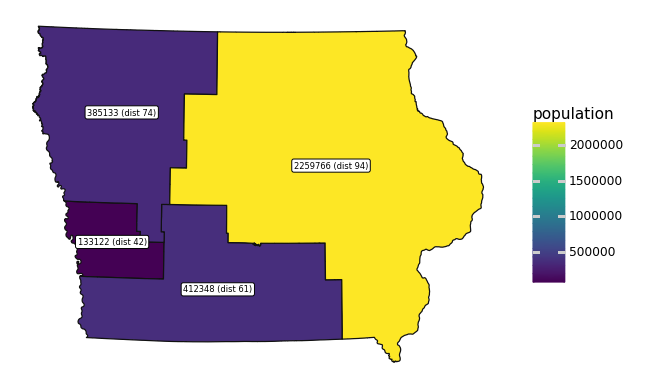

<ggplot: (357033582)>

In [29]:
map_merged_districts(shapef_ia_initialdistricting,'combined_label')

In [30]:
shapef_ia_initialdistricting[['population','temp_district']]

,population,temp_district
0,133122,42
1,412348,61
2,385133,74
3,2259766,94


# Begin step 3: redistributing counties until population is within bounds

In [31]:
# helper function: input is a shapefile with 'population' 
# column. output is a full matrix with SIGNED
# population differences between attributes
# row - col
# positive value in row i column j means that pop(i) > pop(j)
# negative value in row i column j means that pop(i) < pop(j)
def pop_diff_matrix(temp_shapefile):
    curr_n_districts = len(temp_shapefile)
    pop_diff_mat = np.zeros((curr_n_districts,curr_n_districts))

    for i in range(curr_n_districts):
        for j in range(curr_n_districts):   
            pop_diff_mat[i,j] = temp_shapefile['population'].iloc[i] - temp_shapefile['population'].iloc[j]
    
    return pop_diff_mat


## helper function: given a dataframe of movable counties
# and another dataframe of the district they're going to
# make a list of relative distances
def calculate_rel_dist(border_counties,new_district):
    n_border_counties = len(border_counties)
    distance_list = np.zeros((n_border_counties,3))

    for i in range(n_border_counties):
        oldx_dist = border_counties['xcentr_lon_2'].iloc[i] - border_counties['xcentr_lon_1'].iloc[i]
        oldy_dist = border_counties['ycentr_lat_2'].iloc[i] - border_counties['ycentr_lat_1'].iloc[i]

        # old_dist
        distance_list[i,0] = math.sqrt(oldx_dist**2 + oldy_dist**2)

        newx_dist = border_counties['xcentr_lon_2'].iloc[i] - new_district['xcentr_lon'].iloc[0]
        newy_dist = border_counties['ycentr_lat_2'].iloc[i] - new_district['ycentr_lat'].iloc[0]

        # new_dist
        distance_list[i,1] = math.sqrt(newx_dist**2 + newy_dist**2)

        ## relative_distance: old - new
        # we'll move the county with highest relative distance
        distance_list[i,2] = distance_list[i,0] - distance_list[i,1]

    #we only need relative distances, not the component parts
    #so we could just make an n x 1 list instead of n x 3
    rel_dist = distance_list[:,2]
    return rel_dist


# switch_func helper function
# input is a dataframe with potentially movable counties (and a count of switches)
# output is a county to switch: first priority: below threshold of switches (and population)
#    Then, max relative distance of what's left
def switch_func(dataframe):
    dataframe_sorted = dataframe.sort_values('rel_distance',ascending=False).copy()
    #gives the column index for num_switches 
    switch_index=dataframe_sorted.columns.get_loc('num_switches')
    rel_distance_index = dataframe_sorted.columns.get_loc('rel_distance')
    # min_switches=min(dataframe['num_switches'])
    for i in range(dataframe_sorted.shape[0]):
        if (dataframe_sorted.iloc[i]['num_switches'] <= switches_threshold) & (dataframe_sorted.iloc[i]['population_2']<pop_limit_switch):
            # dataframe_sorted.iloc[i,switch_index]+=1
            # movingcounty_index=i
            print(dataframe_sorted.iloc[i]['COUNTYFP10'])
            break
        else:
            print('This county does not satisfy the num_switch and population threshold criteria')  

In [32]:
# adding switch_count to county shapefile which we will be using
#
shapef_counties_for_realloc = shapef_ia_fordistricting.copy()

# make a column with num_switches
shapef_counties_for_realloc['num_switches'] = np.zeros(shapef_counties_for_realloc.shape[0],dtype=int)

In [34]:
#9/13 note: update names of shapef_ia_redist to make sure it's clear what is in the rows.
# drop: 'NAME10' (was just "2" for most-recently-merged attribute)
#       'COUNTYFP10' (concatenated FIPS code)
#       'county_id'  (summed county ids) 
#       'temp_district'  (1 arbitrary "root" county code) 
shapef_ia_redist = shapef_ia_initialdistricting.drop(columns=['NAME10', 'COUNTYFP10','county_id','temp_district']).copy()

# make a column with a district #, 1-4
shapef_ia_redist['district_label'] = shapef_ia_redist.index + 1

# Making separate geodataframes for each district (one district/attribute in each).
list_of_districts=[]
for i in range(4):
    list_of_districts.append(shapef_ia_redist.iloc[[i]].reset_index(drop=True))

#the identity overlay takes district n and splits it up by all counties
# which fall inside it (from main, un-districted shapefile)
#keep_geom_type=True   discards boundary points and lines from counties which only border the district
#resulting dataframe columns: _1 stuff comes from parent (whole district)
#                             _2 stuff comes from specific county
list_of_counties=[]
for i in range(4):
    list_of_counties.append(list_of_districts[i].overlay(shapef_counties_for_realloc,how='identity',keep_geom_type=True))

In [35]:
#this records the district number each county is assigned to in the first pass
shapef_counties_for_realloc['DISTRICT']=''
for i in range(99):
    for j in range(4):
        # if i<j:
        if shapef_counties_for_realloc.iloc[i]['COUNTYFP10'] in list_of_counties[j]['COUNTYFP10'].tolist():
            shapef_counties_for_realloc.loc[i,'DISTRICT']=j+1
shapef_counties_for_realloc

,COUNTYFP10,NAME10,geometry,population,county_id,xcentr_lon,ycentr_lat,county_id_string,temp_district,num_switches,DISTRICT
0,001,Adair,"POLYGON ((386139.673 4557123.147, 385899.972 4...",7496,0,376909.476792,4.576509e+06,00,0,0,2
1,003,Adams,"POLYGON ((347722.464 4557927.937, 347913.212 4...",3704,1,357154.753953,4.543364e+06,01,1,0,2
2,005,Allamakee,"POLYGON ((621990.182 4817526.586, 622024.806 4...",14061,2,631594.469070,4.793646e+06,02,2,0,4
3,007,Appanoose,"POLYGON ((491767.058 4517888.762, 491767.214 4...",12317,3,511092.713138,4.510250e+06,03,3,0,2
4,009,Audubon,"POLYGON ((325801.578 4617291.999, 325803.323 4...",5674,4,341387.505752,4.616499e+06,04,4,0,3
...,...,...,...,...,...,...,...,...,...,...,...
94,189,Winnebago,"POLYGON ((421445.925 4808992.344, 421447.824 4...",10679,94,440524.162282,4.803006e+06,94,94,0,4
95,191,Winneshiek,"POLYGON ((574463.517 4808850.424, 574456.858 4...",20070,95,593803.522688,4.793727e+06,95,95,0,4
96,193,Woodbury,"POLYGON ((219197.456 4698279.860, 219185.953 4...",105941,96,249377.945062,4.697544e+06,96,96,0,3
97,195,Worth,"POLYGON ((469254.825 4789243.586, 469110.920 4...",7443,97,478869.195738,4.802759e+06,97,97,0,4


In [36]:
#-----------find neighboring districts with the greatest population difference---------------------
#adjacencey matrix for 4 districts
adj_mat_array = adj_mat_calc(shapef_ia_redist).to_numpy()

#SIGNED population difference array
# row minus col
# positive value in row i column j means that pop(i) > pop(j)
# negative value in row i column j means that pop(i) < pop(j)
pop_diff_array = pop_diff_matrix(shapef_ia_redist)
# zero out any pairs that aren't adjacent
# for numpy arrays, "*" is piecewise multiplication
neighbor_popdiff = adj_mat_array * pop_diff_array

#maxpopdiff_loc is an ordered pair giving the location of the
#maximum value within neighbor_popdiff. Note!! Indexed on (0,n-1)!
maxpopdiff_loc = np.unravel_index(np.argmax(neighbor_popdiff, axis=None), neighbor_popdiff.shape)

#population threshold for a border county that can get moved:
#  half of the difference between the two neighboring districts we're adjusting
#  if dist 1 has pop 700k and dist 2 has pop 1mil, then max size that can be moved
#  from dist 2 to dist 1 is 300k
pop_limit_switch=.5*neighbor_popdiff.max()
pop_limit_switch

#big district is the *row*, so first element of ordered pair
big_dist_index = maxpopdiff_loc[0]
#small district is the *column*, so second element of ordered pair
small_dist_index = maxpopdiff_loc[1]

# big district geodataframe
# should match shapef_ia_redist.iloc[[big_dist_index]]
#    (though with diff indexing, which matters in distance helper fxn)
bigdist = list_of_districts[big_dist_index].copy()
smalldist = list_of_districts[small_dist_index].copy()

#----------find which county will be swapped from "bigdist" to "smalldist"----------------------
#from the list of 4 dataframes (each of diff districts)
#we call the dataframe of the big district
bigdist_counties = list_of_counties[big_dist_index].copy()

#dataframe of counties in the Big district which are 
#adjacent to the Small district so which we might move
#(possible to be point neighbors and have issues -
#should be okay with D criterion, though)
#reset index so it is (0,n-1), instead of sparse indexing based on where the county was within the district
#we retain the original county id in 'county_id'
bigdist_movable = bigdist_counties.loc[bigdist_counties.intersects(smalldist.unary_union)].reset_index(drop=True).copy()

# array with all switch counts from the movable county list
num_switches_array = np.array(bigdist_movable['num_switches'])

# max and min values from the array
max_switches = max(num_switches_array)
min_switches = min(num_switches_array)

# our chosen threshold for switches: halfway between max and min (floor)
switches_threshold = min_switches + np.ceil((max_switches-min_switches)/2)

# adding column to bigdist_movable with relative distances
bigdist_movable['rel_distance'] = calculate_rel_dist(bigdist_movable,smalldist)

In [37]:
# What county should be switched? Humboldt! (FIPS 091)
switch_func(bigdist_movable)

# label this as movingcounty_index for later

091


In [38]:
bigdist_movable.loc[bigdist_movable['COUNTYFP10']=='091']

,population_1,xcentr_lon_1,ycentr_lat_1,county_id_string_1,combined_label,district_label,COUNTYFP10,NAME10,population_2,county_id,xcentr_lon_2,ycentr_lat_2,county_id_string_2,temp_district,num_switches,geometry,rel_distance
2,2259766.0,556068.991335,4.676608e+06,5055882843575347789107367684496337851133184465...,2259766 (dist 94),4.0,091,Humboldt,9597,45,401247.022382,4.736698e+06,45,45,0,"POLYGON ((381703.942 4722528.038, 381707.790 4...",72556.46727


##       END OF STUFF WE'VE WORKED ON IN SEPTEMBER

BELOW IS JUNE STUFF

In [65]:
# June ideas (reviewed and cleaned as of 9/11/23)
#     #return county id of county we're taking out
#     #another option would be to do this geopandas-style?
#     county_to_move = bigdist_movable.iloc[[movingcounty_index]]
#     county_id_to_move = bigdist_movable.loc[movingcounty_index,'county_id']

#     #-----------swap county between districts---------------------------

#     # 2 options: geopandas overlay stuff, or rebuild district dataframe from list of counties in it
#     # currently working the first way, but iterations of overlay are bad

In [ ]:
# Game plan to move FIPS 091 (as proof of concept):
#      -use switch_fun to identify border county to move
#     -bigdist_movable.loc[bigdist_movable['COUNTYFP10']==switch_func(bigdist_movable)]
# -move FPS 091, update its district number
# -write a function to update all district sub-dataframes
# -read through old code below and run it with new variables on 9/13 to see what needs adjusting 

### visualizations

In [39]:
#input: shapefile of counties within a particular district 
#   (after undergoing identity overlay)
#   label_field options: 'NAME10', 'population_2', 'county_id', 'county_id_string_2', etc
def map_unmerged_districts(new_shapefile,label_field):
    map_counties_by_district = (
        ggplot(new_shapefile)
        + geom_map(aes(fill='population_2'))
        + geom_label(aes(x='xcentr_lon_2', y='ycentr_lat_2', 
                        label=label_field,size=2), 
                    show_legend=False)
        + theme_minimal()
        + theme(axis_text_x=element_blank(),
                axis_text_y=element_blank(),
                axis_title_x=element_blank(),
                axis_title_y=element_blank(),
                axis_ticks=element_blank(),
                panel_grid_major=element_blank(),
                panel_grid_minor=element_blank()
            )
        )

    return map_counties_by_district

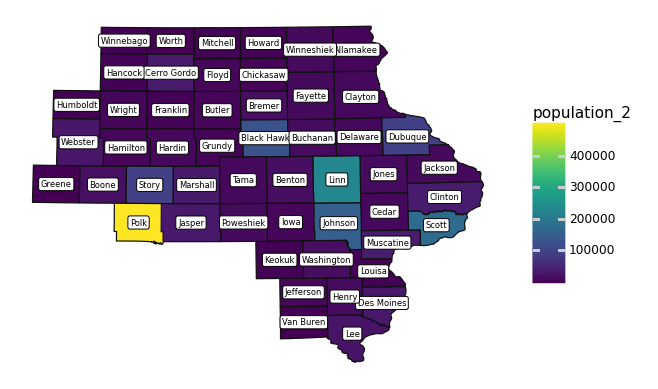

<ggplot: (360093426)>

In [40]:
#this gives an example of output of map_unmerged_districts
map_unmerged_districts(list_of_counties[3],'NAME10')

## future steps

From Chen's paper:

(3a) Among all pairs of districts that border one another, identify the pair with the greatest disparity in district population. Within this pair,
let us denote the more populated district as $i$ and the less populated district as $j$.

(3b) Identify the set of all precincts currently within district $i$ that could be reassigned to district $j$ without violating the geographic contiguity of either district $i$ or $j$.

(3c) For each precinct $p$ satisfying the criterion in step 3b, define $D_p$ as precinct $p$’s geographic distance to the centroid of district $i$, minus
precinct $p$’s distance to the centroid of district $j$.

(3d) Among the set of precincts satisfying the criteria in step 3b, select the precinct, $p$, with the highest value of Dp . Reassign this precinct from
district $i$ to district $j$.

## District size bounds

In [41]:
ideal_district_size=state_population/n_districts
tolerance=.01
district_maximum=int(ideal_district_size*(1+tolerance))
district_minimum=int(ideal_district_size*(1-tolerance))